In [1]:
import os
import json
import pickle
import numpy as np
import pandas as pd
import re

from tqdm import tqdm

from datasets import load_from_disk

from matplotlib import pyplot as plt
import seaborn as sns

# Retrieval을 위한 wikipedia passages 관찰

In [3]:
data_path = "../../data/"
context_path = "wikipedia_documents.json"

with open(os.path.join(data_path, context_path), "r", encoding="utf-8") as f:
    wiki = json.load(f)
wiki["0"], len(wiki)

({'text': '이 문서는 나라 목록이며, 전 세계 206개 나라의 각 현황과 주권 승인 정보를 개요 형태로 나열하고 있다.\n\n이 목록은 명료화를 위해 두 부분으로 나뉘어 있다.\n\n# 첫 번째 부분은 바티칸 시국과 팔레스타인을 포함하여 유엔 등 국제 기구에 가입되어 국제적인 승인을 널리 받았다고 여기는 195개 나라를 나열하고 있다.\n# 두 번째 부분은 일부 지역의 주권을 사실상 (데 팍토) 행사하고 있지만, 아직 국제적인 승인을 널리 받지 않았다고 여기는 11개 나라를 나열하고 있다.\n\n두 목록은 모두 가나다 순이다.\n\n일부 국가의 경우 국가로서의 자격에 논쟁의 여부가 있으며, 이 때문에 이러한 목록을 엮는 것은 매우 어렵고 논란이 생길 수 있는 과정이다. 이 목록을 구성하고 있는 국가를 선정하는 기준에 대한 정보는 "포함 기준" 단락을 통해 설명하였다. 나라에 대한 일반적인 정보는 "국가" 문서에서 설명하고 있다.',
  'corpus_source': '위키피디아',
  'url': 'TODO',
  'domain': None,
  'title': '나라 목록',
  'author': None,
  'html': None,
  'document_id': 0},
 60613)

In [4]:
contexts = list(dict.fromkeys([v["text"] for v in wiki.values()]))
contexts[0], len(contexts)

('이 문서는 나라 목록이며, 전 세계 206개 나라의 각 현황과 주권 승인 정보를 개요 형태로 나열하고 있다.\n\n이 목록은 명료화를 위해 두 부분으로 나뉘어 있다.\n\n# 첫 번째 부분은 바티칸 시국과 팔레스타인을 포함하여 유엔 등 국제 기구에 가입되어 국제적인 승인을 널리 받았다고 여기는 195개 나라를 나열하고 있다.\n# 두 번째 부분은 일부 지역의 주권을 사실상 (데 팍토) 행사하고 있지만, 아직 국제적인 승인을 널리 받지 않았다고 여기는 11개 나라를 나열하고 있다.\n\n두 목록은 모두 가나다 순이다.\n\n일부 국가의 경우 국가로서의 자격에 논쟁의 여부가 있으며, 이 때문에 이러한 목록을 엮는 것은 매우 어렵고 논란이 생길 수 있는 과정이다. 이 목록을 구성하고 있는 국가를 선정하는 기준에 대한 정보는 "포함 기준" 단락을 통해 설명하였다. 나라에 대한 일반적인 정보는 "국가" 문서에서 설명하고 있다.',
 56737)

In [8]:
len([corpus for corpus in contexts if len(corpus) < 3500])

56351

In [55]:
text = []
source = []
url = []
domain = []
title = []
author = []
html = []
document_id = []
for idx in tqdm(range(len(wiki)), desc="Wiki to DataFrame"):
    new = wiki[str(idx)]
    text.append(new['text'])
    source.append(new['corpus_source'])
    url.append(new['url'])
    domain.append(new['domain'])
    title.append(new['title'])
    author.append(new['author'])
    html.append(new['html'])
    document_id.append(new['document_id'])
    
wiki_df = pd.DataFrame({"text":text, "corpus_source":source, "url":url, "domain":domain,
                       "title":title, "author":author, "html":html, "document_id":document_id})

Wiki to DataFrame: 100%|██████████| 60613/60613 [00:00<00:00, 373882.08it/s]


In [56]:
wiki_df.head()

,text,corpus_source,url,domain,title,author,html,document_id
0,"이 문서는 나라 목록이며, 전 세계 206개 나라의 각 현황과 주권 승인 정보를 개...",위키피디아,TODO,None,나라 목록,None,None,0
1,이 목록에 실린 국가 기준은 1933년 몬테비데오 협약 1장을 참고로 하였다. 협정...,위키피디아,TODO,None,나라 목록,None,None,1
2,현 서울특별시 종로구 서린동 (구 일제 강점기 경기도 경성부 서린정) 출신이다. 친...,위키피디아,TODO,None,백남준,None,None,2
3,"아오조라 문고(靑空文庫, あおぞらぶんこ|아오조라 분고)는 ‘일본어판 구텐베르크 프로...",위키피디아,TODO,None,아오조라 문고,None,None,3
4,저자 사망 이후 50년이 지나 저작권이 소멸한 메이지 시대부터 쇼와 시대 초기까지의...,위키피디아,TODO,None,아오조라 문고,None,None,4


In [57]:
len(wiki_df)

60613

## Explore Texts - Length

In [58]:
from transformers import AutoTokenizer

# model_name = "klue/bert-base"
model_name = "xlm-roberta-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [59]:
len_text = [len(tokenizer(txt)['input_ids']) for txt in tqdm(list(wiki_df['text']))]

100%|██████████| 60613/60613 [01:31<00:00, 660.04it/s]


/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


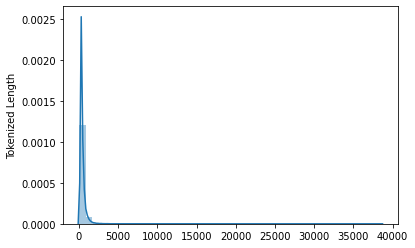

avg : 434
max : 38557
min : 75


In [60]:
sns.distplot(len_text, kde=True)
plt.ylabel("Tokenized Length")
plt.show()
print(f"avg : {sum(len_text)//len(len_text)}")
print(f"max : {max(len_text)}")
print(f"min : {min(len_text)}")

In [61]:
cnt = 0
long_txt = []
for txt in tqdm(wiki_df['text']):
    if len(txt) > 10000:
        cnt += 1
        long_txt.append(txt)
cnt

100%|██████████| 60613/60613 [00:00<00:00, 786719.98it/s]


33

In [62]:
long_df = wiki_df.loc[wiki_df['text'].isin(long_txt)]
long_df

,text,corpus_source,url,domain,title,author,html,document_id
578,";성도(청두)시 成都市\n\n성도,간칭으로 “융”(蓉)이라고 도 한다. 아시에서 처...",위키피디아,TODO,None,쓰촨성,None,None,578
699,1. 번제 : Burnt offering\n\n1) 어의\n- 이스라엘의 5대 제사...,위키피디아,TODO,None,레위기,None,None,699
973,:참고 문헌 목록은 제1차 세계 대전의 서지 문서를 참조하십시오.\n \n* tit...,위키피디아,TODO,None,제1차 세계 대전,None,None,973
3263,일 년전쟁시 V작전의 발동과 함께 개발된 연방제 모빌 슈트 계획 중 중거리지원형 기...,위키피디아,TODO,None,건캐논,None,None,3263
4543,"인륜을 키미니 례예 둘재라.\n\n○ 孟子曰, 設爲庠序學校, 以敎之. 皆所以明人...",위키피디아,TODO,None,소학언해,None,None,4543
4545,"녜일 고홈이니 례예 넫재라.\n\n○ 孟子道性善, 言必稱堯舜. 其言曰, 舜爲法於...",위키피디아,TODO,None,소학언해,None,None,4545
4547,"아다온 말이니 례예 다재라\n\n○ 橫渠張先生曰, 敎小兒, 先要安詳恭敬. 今...",위키피디아,TODO,None,소학언해,None,None,4547
4548,"어딘 실이니 례예 여재라\n\n○ 呂滎公名希哲, 字原明. 申國正獻公之長子. 正...",위키피디아,TODO,None,소학언해,None,None,4548
5132,";성도(청두)시 成都市\n\n성도,간칭으로 “융”(蓉)이라고 도 한다. 아시에서 처...",위키피디아,None,None,쓰촨성,None,None,5132
5253,1. 번제 : Burnt offering\n\n1) 어의\n- 이스라엘의 5대 제사...,위키피디아,None,None,레위기,None,None,5253


In [63]:
long_txt[0]

';성도(청두)시 成都市\n\n성도,간칭으로 “융”(蓉)이라고 도 한다. 아시에서 처음으로 국제“미식의 도시”(美食之都)로 이름이 났고 고대로 부터”천부지국”(天府之国)이라는 아름다운 명칭을 얻었다.. 이백(李白)의 시편 에는 “아홉개 하늘은 성도에서 나왔고 천만개의 문은 그림으로 들어 오너라” (九天开出一成都，万户千门入画图) 진절하게 금관성(锦官城)의 부유와 수려함을 묘사 하였다. 사천의 전통극은 절기하고 풍부하며 례로 타거(托举), 개혜안(开慧眼), 얼굴 변하기(变脸), 불뿜기(喷火), 칼숨기기(藏刀)등은 사람들로 하여금 감탄을 끓이지 않 았다. 성도는 2010년 2월 28일에 “미식의 도시”로 칭호를 수여 받았다. 성도의 유명한 소식(著名小吃)은 마퍼 두부(麻婆豆腐), 쌍류 토끼 두(双流兔头), 부처폐편(夫妻肺片), 단단면(担担面), 용 초수(龙抄手), 종 물 만두(钟水饺), 한 만두 떡(韩包子), 삼대 포(三大炮), 뢰탕원(赖汤圆)등이다. 성도의 가장 좋은 여행 시간은 3월, 4월, 5월, 6월, 9월, 10월, 11월이며 청성산(青城山), 서령 설산(西岭雪山), 구룡구(九龙沟), 구봉산(九峰山), 천대산(天台山), 용지 산림공원(龙池森林公园) 등은 모두 성도의 가장 이상적인 피서 명승지이다. 성도에서 북쪽으로 올라 가다 보면 도강언(都江堰), 구채구(九寨沟)로 도달할 수 있고 서쪽의 천장 도로(川藏公路)를 따라 올라 가면 라싸(拉萨) 로 통하며 촬영 성지인 경로에는 신도교(新都桥) 해라구 빙천(海螺沟冰川), 임지(林芝) 등지 망강(芒康)에서 남쪽으로 내려가다 보면 매리설산(梅里雪山), 샹그리라(香格里亚), 려강(丽江)등 주요 여행 경치 지역이 나타 난다.\n\n;덕양시 德阳市\n덕양은 역사가 유구하고 파촉문화 발원지 중의 하나이며 여행자원은 하늘의 두터운 특혜를 가져 독특하다. 국내외 에서도 유명한 국가 중점 문화물 보호 단위(国家重点文物保护单位)이며 국가 처음으로의4A 급 풍경 명승지의 고대 촉국의 삼성퇴(三星堆)유적지; 보존이 완호하며 건축이 정밀

In [64]:
long_txt[10]

':참고 문헌 목록은 제1차 세계 대전의 서지 문서를 참조하십시오.\n \n* title=American Armies and Battlefields in Europe: A History, Guide, and Reference Book|publisher=US Government Printing Office|year=1938|url=http://www.secstate.wa.gov/history/ww1/maps.aspx|oclc=59803706|author=American Battle Monuments Commission\n* title=Army Art of World War I|publisher=United States Army Center of Military History: Smithsonian Institution, National Museum of American History|year=1993|url=http://www.secstate.wa.gov/history/publications_detail.aspx?p=28|oclc=28608539|author1=\n* last=Bade|first=Klaus J|last2=Brown|first2=Allison (tr.)|title=Migration in European History|series=The making of Europe|location=Oxford|publisher=Blackwell|year=2003|isbn=0-631-18939-4|oclc=52695573 (translated from the German)\n* last=Baker|first=Kevin|title=Stabbed in the Back! The past and future of a right-wing myth|periodical=Harper\'s Magazine|date=June 2006\n* last=Balakian|first=Peter|title=The Burning Tigris: The Armenian Genocide and Ame

In [65]:
long_txt[20]

'1948년 8월 15일, 대한민국 정부가 수립되었다.\n\n이 시기에는 좌익과 우익 간의 대립이 극에 달하여 정부 수립 직전인 1948년 4월에는 단정단선론에 반대하는 남로당 김달삼의 주도 하에 제주 4·3 사건이 발생됐고, 같은 해 10월에는 제주 4.3 사건 진압을 명령 받은 국군 제14연대가 남로당 김지회, 지창수를 중심으로 반란을 일으킨 여수·순천 사건이 발생되었다. 그 이전부터 공산진영과 비공산진영 간의 갈등과 무력출동은 잦았지만, 공산당이 동족을 대상으로 여수·순천 사건이라는 대규모 군사반란까지 일으키자 모두가 충격을 받았다. 이승만 정부는 좌우익 간의 갈등을 극복하고 사회질서를 확립한다는 명분으로 반공주의 정책을 내세웠다. 그리고 1948년 12월 1일에는 국헌을 위배하여 정부를 참칭하거나 국가를 변란할 목적으로 단체를 구성하는 등 국가안보를 위태롭게 하는 각종의 행위를 처벌할 목적으로 국가보안법을 제정하였다\n\n이러한 가운데 1948년 8월 19일 반민족행위처벌법 초안이 국회에 상정되자 국회 내의 공기는 찬반 양론으로 대립하였다. 반민족행위처벌법 국회 통과시 타격을 면치 못할 한민당은 \'동 법안(반민족행위처벌법)이 필요는 하나 민중의 혼란을 초래할 우려가 있고, 또 동 법안은 너무나 추상적이니 법제위원회로 회부하자\'는 의견을 냈다 1948년 8월 23일 한국민주당의 당수 김성수는 친일파·민족반역자 숙청을 강경히 주장하는 의원들에게 회견을 청하여 친일파 문제를 광범하게 취급할 것이 아니라 범위를 좁게 취급할 것을 요청했다 1948년 8월 26일 반민족행위처벌법이 국회에서 논의되기 시작하자 한국민주당에 매월 20만 원 정도를 제공하던 친일재벌 金모씨는 돌연 동 법안을 완화 또는 무능화하도록 공작하는 자금으로서 2천만 원이라는 거액을 한국민주당에 제공하였다 1948년 8월 27일 신익희 국회의장이 반민족행위가 있는 정부위원들의 임명을 승인하자 이에 반발하여 반민특위 전원이 사임하는 사태가 벌어졌다. \n\n1948년 9월 22일 제헌 국회는 반

## Explore Texts - Tokenize

In [66]:
num_unk = 0
for txt in tqdm(wiki_df['text']):
    encoded = tokenizer(txt)['input_ids']
    if 3 in encoded:
        num_unk += 1
        continue
print(f"Number of [UNK] included : {num_unk}/{len(wiki_df)}")

100%|██████████| 60613/60613 [01:37<00:00, 624.16it/s]

Number of [UNK] included : 5012/60613


### Documents를 preprocess 하는 방식은 retrieval과 mrc에서 모두 동일해야함
### -> '\n' 제거 등과 같은 공통 전처리 전략 필요

In [49]:
def simple_preprocess(txt):
    txt = re.sub("[(\n)\]", "", txt)
    txt = ' '.join(txt.split())
    return txt

In [50]:
simple_preprocess(long_txt[20])

error: unterminated character set at position 0 (line 1, column 1)